In [25]:
import jax
import jax.numpy as jnp
import numpyro
import arviz as az
import numpy as np
import scipy.stats as stats
import numpyro.distributions as dist
import matplotlib.pyplot as plt

In [3]:
y= jnp.array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0])

2022-09-18 12:57:22.321598: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-09-18 12:57:22.321633: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
def model(y):
    #事前分布のパラメータ
    alpha = jnp.array(1.0)
    beta  = jnp.array(1.0)
    
    #　推論対象とするパラメータの事前分部
    theta = numpyro.sample('theta', numpyro.distributions.Beta(alpha,beta))
    
    with numpyro.plate('samples', len(y)):
        
        numpyro.sample('obs', numpyro.distributions.Bernoulli(theta), obs=y)                    

In [5]:
kernel = numpyro.infer.NUTS(model)

mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=3)

/tmp/ipykernel_345/1641927478.py:3: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=3)


In [6]:
mcmc.run(jax.random.PRNGKey(1), y=y)

sample: 100% 2500/2500 [00:02<00:00, 993.90it/s, 1 steps of size 1.16e+00. acc. prob=0.91] 
sample: 100% 2500/2500 [00:01<00:00, 1875.97it/s, 3 steps of size 1.16e+00. acc. prob=0.93]
sample: 100% 2500/2500 [00:01<00:00, 1887.50it/s, 3 steps of size 8.02e-01. acc. prob=0.92]


array([[<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

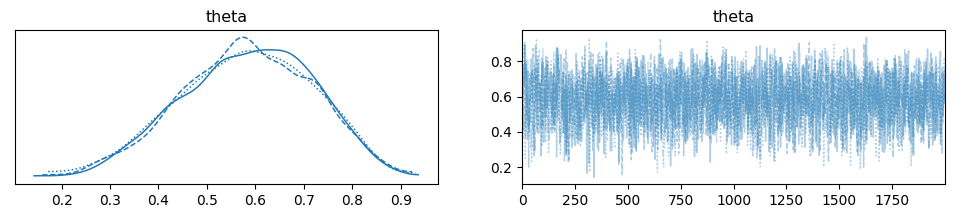

In [9]:
az.plot_trace(mcmc)

In [10]:
az.summary(mcmc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.582,0.136,0.34,0.836,0.003,0.002,2192.0,2943.0,1.0


In [11]:
samples = mcmc.get_samples()

mcmcm sample mean: 0.582
mcmcm sample std: 0.136
true posterior mean: 0.583
true posterior std: 0.137


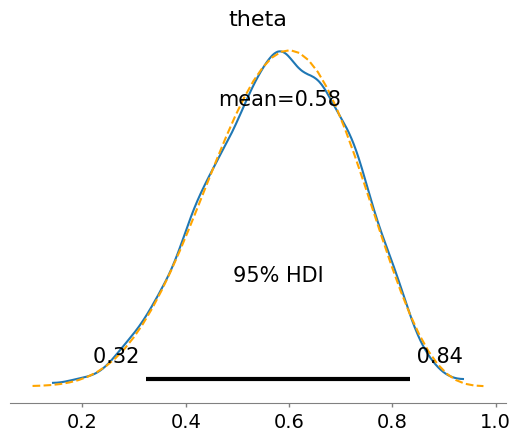

In [18]:
ax = az.plot_posterior(samples,hdi_prob=0.95)
x_lin = np.linspace(*ax.get_xlim())

#真の事後分布
true_posterior = stats.beta(1 + np.sum(y), 1+ 10 -np.sum(y))

#真の事後分布の可視化
ax.plot(x_lin, true_posterior.pdf(x_lin), ls='--', color='orange')

print('mcmcm sample mean: {:.3f}'.format(samples['theta'].mean()))
print('mcmcm sample std: {:.3f}'.format(samples['theta'].std()))
print('true posterior mean: {:.3f}'.format(true_posterior.mean()))
print('true posterior std: {:.3f}'.format(true_posterior.std()))